In [120]:
from multitask.benchmarks.kinetic_models import(
    StereoSelectiveReaction, 
    create_pcs_ds,
    MultitaskKinetics
)
from multitask.strategies import NewSTBO, NewMTBO
from summit import *
from botorch.models import SingleTaskGP
from gpytorch.kernels.matern_kernel import MaternKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
import torch
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf, optimize_acqf_mixed
from gpytorch.mlls.exact_marginal_log_likelihood import (
    ExactMarginalLogLikelihood,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

Matern/SE kernel w/ ARD for categorical * Matern/SE kernel with ARD for continuous

In [121]:
device = "cpu"
dtype = torch.double

In [122]:
exp = MultitaskKinetics.load_yaml("case_1.yaml")

In [123]:
strategy = LHS(exp.domain)
conditions = strategy.suggest_experiments(96)
results = exp.run_experiments(conditions)

In [124]:
transform = Transform(exp.domain)
inputs, output = transform.transform_inputs_outputs(
    results,
    categorical_method="one-hot",
    # standardize_inputs=True,
    min_max_scale_inputs=True,
    standardize_outputs=True,
)

In [125]:
X = torch.tensor(
    inputs.data_to_numpy().astype(float),
    device=device,
    dtype=dtype,
)
y = torch.tensor(
    output.data_to_numpy().astype(float),
    device=device,
    dtype=dtype,
)
input_batch_shape, batch_shape = SingleTaskGP.get_batch_dimensions(X, y)

In [126]:
train_X, test_X, train_y, test_y = train_test_split(X, y)

In [ ]:
def train_score_model(X, y kernel):

In [127]:
cat_dims = list(range(13))
ord_dims = [13,14,15]

In [128]:
sum_kernel = ScaleKernel(
    MaternKernel(
        nu=2.5,
        batch_shape=batch_shape,
        ard_num_dims=len(ord_dims),
        active_dims=ord_dims,
    )
    + MaternKernel(
        nu=2.5,
        batch_shape=batch_shape,
        ard_num_dims=len(cat_dims),
        active_dims=cat_dims,
    )
)
prod_kernel = ScaleKernel(
    MaternKernel(
        nu=2.5,
        batch_shape=batch_shape,
        ard_num_dims=len(ord_dims),
        active_dims=ord_dims,
    )
    * MaternKernel(
        nu=2.5,
        batch_shape=batch_shape,
        ard_num_dims=len(cat_dims),
        active_dims=cat_dims,
    )
)
covar_module = sum_kernel +  prod_kernel

In [129]:
model = SingleTaskGP(train_X, train_y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll, max_retries=20)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

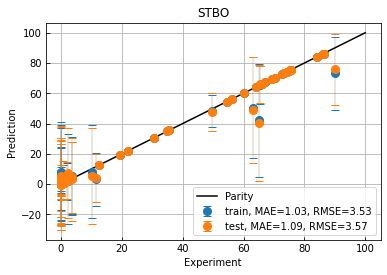

In [130]:
fig, ax = plt.subplots(1, figsize=(6,4))
labels = ["train", "test"]
for i, xi in enumerate([train_X, test_X]):
    with torch.no_grad():
        posterior = model.posterior(X)
        samples = [posterior.sample() for i in range(100)]
    samples = torch.stack(samples).squeeze()
    pred_mean, pred_std = transform.output_means["yld"], transform.output_stds["yld"]
    samples = samples*pred_std + pred_mean
    samples_mean = samples.mean(axis=0)
    samples_std = samples.std(axis=0)

    mae = mean_absolute_error(results["yld"], samples_mean)
    rmse = mean_squared_error(results["yld"], samples_mean)**(0.5)
    ax.errorbar(
        results["yld"],
        samples_mean,
        yerr=1.96*samples_std,
        label=f"{labels[i]}, MAE={mae:.02f}, RMSE={rmse:0.02f}",
        linewidth=0,
        marker="o",
        markersize=8,
        elinewidth=0.2,
        capsize=4.0,

    )
    
ax.grid()
# ax.errorbar(
#     results["yld"].iloc[-1],
#     samples_mean[-1],
#     yerr=1.96*samples_std[-1],
#     label = "Case B pred",
#     linewidth=0,
#     marker="o",
#     markersize=8,
#     elinewidth=0.2,
#     capsize=5.0
# )
# ax.scatter(data["yld"].iloc[23:], samples_mean[23:], label = "Task B", c="orange")
ax.plot([0,100],[0,100], label="Parity", c="black")
ax.set_xlabel("Experiment")
ax.set_ylabel("Prediction")
ax.tick_params(direction="in")
ax.set_title("STBO")
ax.legend()